# MUBI Dataset Preprocessing

In [1]:
import pandas as pd
import numpy as np
import math
import re
from scipy.sparse import csr_matrix
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("darkgrid")

In [2]:
import os
import sys

In [5]:
# Load data 42 secs
df1 = pd.read_csv("mubi_ratings_data.csv")


C:\Users\Alvi\AppData\Local\Temp\ipykernel_22336\2082741419.py:1: DtypeWarning: Columns (9,10,11,12) have mixed types. Specify dtype option on import or set low_memory=False.
  df1 = pd.read_csv("mubi_ratings_data.csv")


In [6]:
df1.head()

,movie_id,rating_id,rating_url,rating_score,rating_timestamp_utc,critic,critic_likes,critic_comments,user_id,user_trialist,user_subscriber,user_eligible_for_trial,user_has_payment_method
0,1066,15610495,http://mubi.com/films/pavee-lackeen-the-travel...,3.0,2017-06-10 12:38:33,NaN,0,0,41579158,False,False,True,False
1,1066,10704606,http://mubi.com/films/pavee-lackeen-the-travel...,2.0,2014-08-15 23:42:31,NaN,0,0,85981819,True,True,False,True
2,1066,10177114,http://mubi.com/films/pavee-lackeen-the-travel...,2.0,2014-01-30 13:21:57,NaN,0,0,4208563,False,False,True,True
3,1066,10130280,http://mubi.com/films/pavee-lackeen-the-travel...,3.0,2014-01-19 01:04:23,I am a bit disappointed by this documentary fi...,0,0,9820140,False,False,True,False
4,1066,8357049,http://mubi.com/films/pavee-lackeen-the-travel...,4.0,2012-10-02 18:28:47,NaN,0,0,68654088,False,False,True,True


In [9]:
df = df1.loc[:,["movie_id","rating_score","user_id"]]
del df1

In [10]:
df.head()

,movie_id,rating_score,user_id
0,1066,3.0,41579158
1,1066,2.0,85981819
2,1066,2.0,4208563
3,1066,3.0,9820140
4,1066,4.0,68654088


In [12]:
print(len(df))
df.drop_duplicates(inplace=True)
print(len(df))


15520005
15519989


In [13]:
df["rating_score"].value_counts()

rating_score
4.0    5271042
3.0    4156583
5.0    3570833
2.0    1723743
1.0     771057
Name: count, dtype: int64

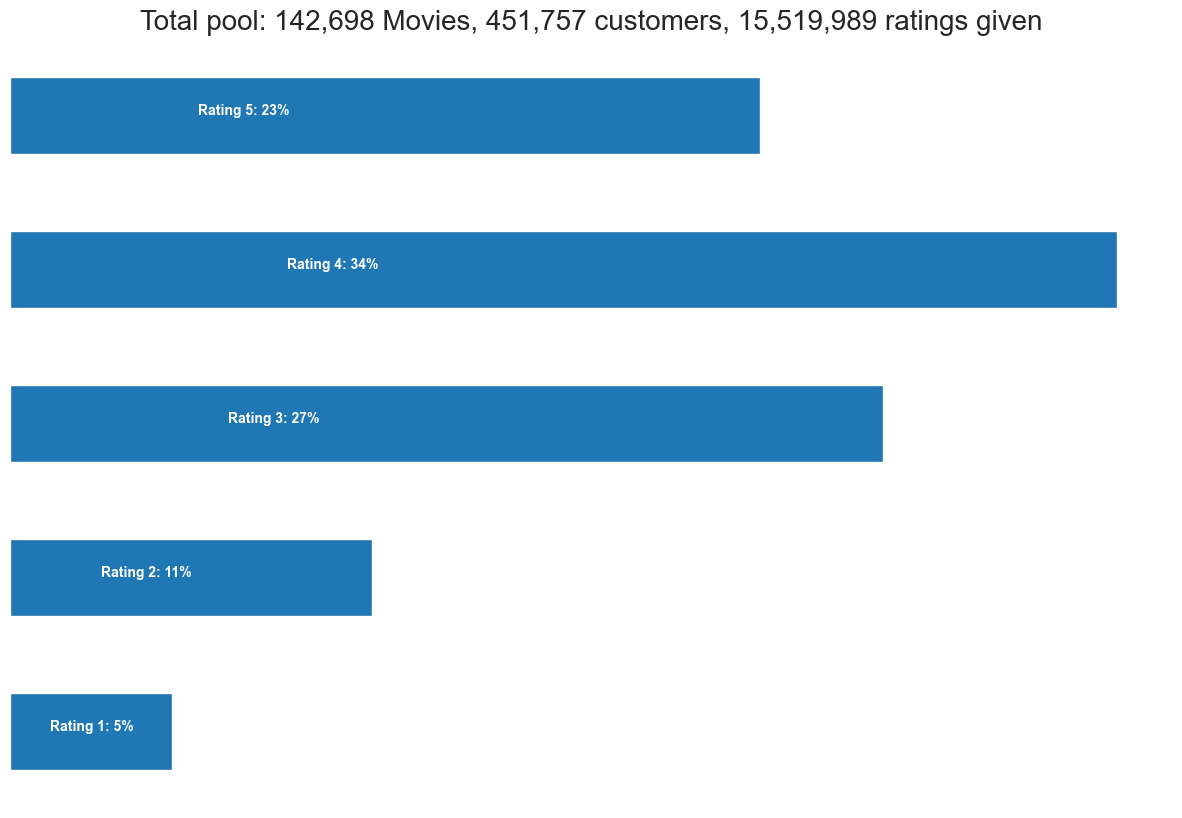

In [14]:
# 50 sec+
p = df.groupby('rating_score')['rating_score'].agg(['count'])

# get movie count
movie_count = df["movie_id"].nunique()

# get customer count
cust_count = df['user_id'].nunique()

# get rating count
rating_count = len(df)

ax = p.plot(kind = 'barh', legend = False, figsize = (15,10))
plt.title('Total pool: {:,} Movies, {:,} customers, {:,} ratings given'.format(movie_count, cust_count, rating_count), fontsize=20)
plt.axis('off')

for i in range(1,6):
    ax.text(p.iloc[i-1][0]/4, i-1, 'Rating {}: {:.0f}%'.format(i, p.iloc[i-1][0]*100 / p.sum()[0]), color = 'white', weight = 'bold')

## Filteration Criteria

(Based on NEtflix Preprocessing)
</br>
1. Only keep Rows where user has provided rating more than 4 (4 and 5)
2. Only keep data about recipe which were atleast reviewed once(or user provided input)
3. Only keep data  users  whol reviewd atleast five recipes(or user provided input)

In [17]:
#1.binarize the data(Only Keep rating 5)
df_filtered=df[df["rating_score"]>=4]


In [22]:
print("Review records before filteration {0:d} and after filteration records {1:d}".format(len(df), len(df_filtered)))

Review records before filteration 15519989 and after filteration records 8841875


In [26]:
del df

In [23]:
def get_count(tp, id):
    """ 
    Acts very similar to value counts for particular column and \
    can be used filtering the indexes by triplet fucntion
    """
    playcount_groupbyid = tp[[id]].groupby(id, as_index=False)
    count = playcount_groupbyid.size()
    return count

def filter_triplets(tp,min_uc=5,min_sc=0):
    """
    FIltering based on count of recipe reviewed by user and count users who reviewed the certain amount of recipe
    """
    # Only keep the triplets for items which were rated at least min_sc times
    if min_sc > 0:
        itemcount = tp["movie_id"].value_counts()
        tp = tp[tp["movie_id"].isin(itemcount.index[itemcount >= min_sc])]
    # Only keep the triplets for users who have rated at least min_uc items
    # After doing this, some of the items will have less than min_uc users, but should only be a small proportion
    if min_uc > 0:
        usercount = tp["user_id"].value_counts()
        tp = tp[tp["user_id"].isin(usercount.index[usercount >= min_uc])]
    # Update both usercount and itemcount after filtering
    usercount, itemcount = tp["user_id"].value_counts(), tp["movie_id"].value_counts() 
    return tp, usercount, itemcount

In [25]:
raw_data, user_activity, item_popularity = filter_triplets(df_filtered, min_uc=5, min_sc=0)

In [29]:
len(user_activity), df_filtered["user_id"].nunique(), len(item_popularity), df_filtered["movie_id"].nunique()

(130114, 401386, 94496, 96926)

In [31]:
sparsity = 1. * raw_data.shape[0] / (user_activity.shape[0] * item_popularity.shape[0])

print("After filtering, there are %d watching events from %d users and %d movies (sparsity: %.3f%%)" % 
      (raw_data.shape[0], user_activity.shape[0], item_popularity.shape[0], sparsity * 100))

After filtering, there are 8412310 watching events from 130114 users and 94496 movies (sparsity: 0.068%)


In [32]:
unique_uid = user_activity.index

np.random.seed(98765)
idx_perm = np.random.permutation(unique_uid.size)
unique_uid = unique_uid[idx_perm]

In [33]:
# create train/validation/test users
n_users = unique_uid.size
print(n_users)

130114


In [34]:
# create train/validation/test users
n_users = unique_uid.size
n_heldout_users = 40000

tr_users = unique_uid[:(n_users - n_heldout_users * 2)]
vd_users = unique_uid[(n_users - n_heldout_users * 2): (n_users - n_heldout_users)]
te_users = unique_uid[(n_users - n_heldout_users):]

In [36]:
train_plays = raw_data.loc[raw_data['user_id'].isin(tr_users)]


In [37]:
unique_sid = pd.unique(train_plays['movie_id'])

In [38]:
show2id = dict((sid, i) for (i, sid) in enumerate(unique_sid))# Movie Id to index
profile2id = dict((pid, i) for (i, pid) in enumerate(unique_uid))# Uid to index

In [39]:
def split_train_test_proportion(data, test_prop=0.2):
    data_grouped_by_user = data.groupby('user_id')
    tr_list, te_list = list(), list()

    np.random.seed(98765)

    for i, (_, group) in enumerate(data_grouped_by_user):
        n_items_u = len(group)

        if n_items_u >= 5:
            idx = np.zeros(n_items_u, dtype='bool')
            idx[np.random.choice(n_items_u, size=int(test_prop * n_items_u), replace=False).astype('int64')] = True

            tr_list.append(group[np.logical_not(idx)])
            te_list.append(group[idx])
        else:
            tr_list.append(group)

        if i % 1000 == 0:
            print("%d users sampled" % i)
            sys.stdout.flush()

    data_tr = pd.concat(tr_list)
    data_te = pd.concat(te_list)
    
    return data_tr, data_te

In [40]:
vad_plays = raw_data.loc[raw_data['user_id'].isin(vd_users)]
vad_plays = vad_plays.loc[vad_plays['movie_id'].isin(unique_sid)]

In [41]:
vad_plays_tr, vad_plays_te = split_train_test_proportion(vad_plays)

0 users sampled
1000 users sampled
2000 users sampled
3000 users sampled
4000 users sampled
5000 users sampled
6000 users sampled
7000 users sampled
8000 users sampled
9000 users sampled
10000 users sampled
11000 users sampled
12000 users sampled
13000 users sampled
14000 users sampled
15000 users sampled
16000 users sampled
17000 users sampled
18000 users sampled
19000 users sampled
20000 users sampled
21000 users sampled
22000 users sampled
23000 users sampled
24000 users sampled
25000 users sampled
26000 users sampled
27000 users sampled
28000 users sampled
29000 users sampled
30000 users sampled
31000 users sampled
32000 users sampled
33000 users sampled
34000 users sampled
35000 users sampled
36000 users sampled
37000 users sampled
38000 users sampled
39000 users sampled


In [42]:
test_plays = raw_data.loc[raw_data['user_id'].isin(te_users)]
test_plays = test_plays.loc[test_plays['movie_id'].isin(unique_sid)]

In [43]:
test_plays_tr, test_plays_te = split_train_test_proportion(test_plays)

0 users sampled
1000 users sampled
2000 users sampled
3000 users sampled
4000 users sampled
5000 users sampled
6000 users sampled
7000 users sampled
8000 users sampled
9000 users sampled
10000 users sampled
11000 users sampled
12000 users sampled
13000 users sampled
14000 users sampled
15000 users sampled
16000 users sampled
17000 users sampled
18000 users sampled
19000 users sampled
20000 users sampled
21000 users sampled
22000 users sampled
23000 users sampled
24000 users sampled
25000 users sampled
26000 users sampled
27000 users sampled
28000 users sampled
29000 users sampled
30000 users sampled
31000 users sampled
32000 users sampled
33000 users sampled
34000 users sampled
35000 users sampled
36000 users sampled
37000 users sampled
38000 users sampled
39000 users sampled


### Save the data into (user_index, item_index) format

In [44]:
pro_dir = "./"

if not os.path.exists(pro_dir):
    os.makedirs(pro_dir)

with open(os.path.join(pro_dir, 'unique_sid.txt'), 'w') as f:
    for sid in unique_sid:
        f.write('%s\n' % sid)

In [45]:
def numerize(tp):
    uid = list(map(lambda x: profile2id[x], tp['user_id']))
    sid = list(map(lambda x: show2id[x], tp['movie_id']))
    return pd.DataFrame(data={'uid': uid, 'sid': sid}, columns=['uid', 'sid'])

In [46]:
train_data = numerize(train_plays)
train_data.columns, train_data.shape

(Index(['uid', 'sid'], dtype='object'), (3222869, 2))

In [48]:
train_data.to_csv(os.path.join(pro_dir, 'train.csv'), index=False)

In [50]:
vad_data_tr = numerize(vad_plays_tr)
vad_data_tr.columns, vad_data_tr.shape

(Index(['uid', 'sid'], dtype='object'), (2075088, 2))

In [51]:

vad_data_tr.to_csv(os.path.join(pro_dir, 'validation_tr.csv'), index=False)

In [52]:
vad_data_te = numerize(vad_plays_te)
vad_data_te.to_csv(os.path.join(pro_dir, 'validation_te.csv'), index=False)

In [53]:
test_data_tr = numerize(test_plays_tr)
test_data_tr.to_csv(os.path.join(pro_dir, 'test_tr.csv'), index=False)

In [54]:
test_data_te = numerize(test_plays_te)
test_data_te.to_csv(os.path.join(pro_dir, 'test_te.csv'), index=False)

In [55]:
test_data_te.head()

,uid,sid
0,91176,45130
1,112627,637
2,112627,34831
3,90485,59
4,90485,475


In [56]:
train_data.shape,test_data_te.shape,test_data_tr.shape,vad_data_te.shape,vad_data_tr.shape

((3222869, 2), (500717, 2), (2073626, 2), (501155, 2), (2075088, 2))